In [8]:
import sys
import os

# Adiciona o diretório src ao sys.path
sys.path.append(os.path.abspath(os.path.join('..', 'src')))

# Importa os módulos
from process_tiffs import save_masked_tiff, extract_classification_info, plot_tiff_with_classes

In [1]:
import ee
import pandas as pd
import geopandas as gpd
import numpy as np
from rasterio.mask import mask
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt
import requests
import tempfile
import os

## Para a segunda abordagem vamos precisar de arquivos GeoTif para todos os dias e não apenas anual.

In [2]:
ee.Authenticate(force=True)
service_account = 'pdi-618@projetopdi-430718.iam.gserviceaccount.com'
credentials = ee.ServiceAccountCredentials(service_account, '../dados/projetopdi-430718-5d4f0b0f6064.json')
ee.Initialize(credentials)


Successfully saved authorization token.


In [100]:
# Carregar o shapefile
gdf = gpd.read_file('../dados/shapefile_estacoes_divididas/caatinga_territorios_dividido_SAT.shp')

# Filtrar a região de ID A305
gdf_a305 = gdf[gdf['id'] == 'SAT257']

# Converter a geometria do GeoDataFrame para o formato GeoJSON
geometria = gdf_a305.geometry.values[0].__geo_interface__

In [101]:
# Criar o polígono no Google Earth Engine a partir do GeoJSON
aoi = ee.Geometry(geometria)

# Definir o intervalo de datas de interesse
start_date = '2020-01-01'
end_date = '2020-02-01'

# Carregar a coleção Sentinel-1 e filtrar por data
sentinel1_image = ee.ImageCollection('COPERNICUS/S1_GRD') \
    .filterBounds(aoi) \
    .filterDate(start_date, end_date) \
    .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV')) \
    .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VH')) \
    .filter(ee.Filter.eq('instrumentMode', 'IW')) \
    .mean()  # Calcula a média das imagens no período para reduzir ruído

# Selecionar as bandas VV e VH
sentinel1_image = sentinel1_image.select(['VV', 'VH']).clip(aoi)

# Gerar URL de download direto
url = sentinel1_image.getDownloadURL({
    'scale': 70,  # Resolução espacial do Sentinel-1 70m
    'region': aoi.getInfo()['coordinates'],
    'format': 'GeoTIFF'
})

# Imprimir a URL de download
print("Download URL:", url)

Download URL: https://earthengine.googleapis.com/v1/projects/earthengine-legacy/thumbnails/dccaa34e2d4791b8b281394ade69edf5-3770bd06777a95f5469234c8eb7804c4:getPixels


### Bandas do Sentinel-1 (Radar)

Sentinel-1 é um satélite de radar de abertura sintética (SAR), e as bandas geralmente representam diferentes polarizações do sinal de radar.

1. **Banda VV (Vertical-Vertical):** 
   - Representa a polarização vertical do sinal transmitido e recebido. É sensível à estrutura e orientação da vegetação, ao tipo de terreno, e à umidade do solo.

2. **Banda VH (Vertical-Horizontal):**
   - Representa a polarização vertical do sinal transmitido e a horizontal do sinal recebido. Esta banda é útil para diferenciar tipos de vegetação e para detecção de mudanças.


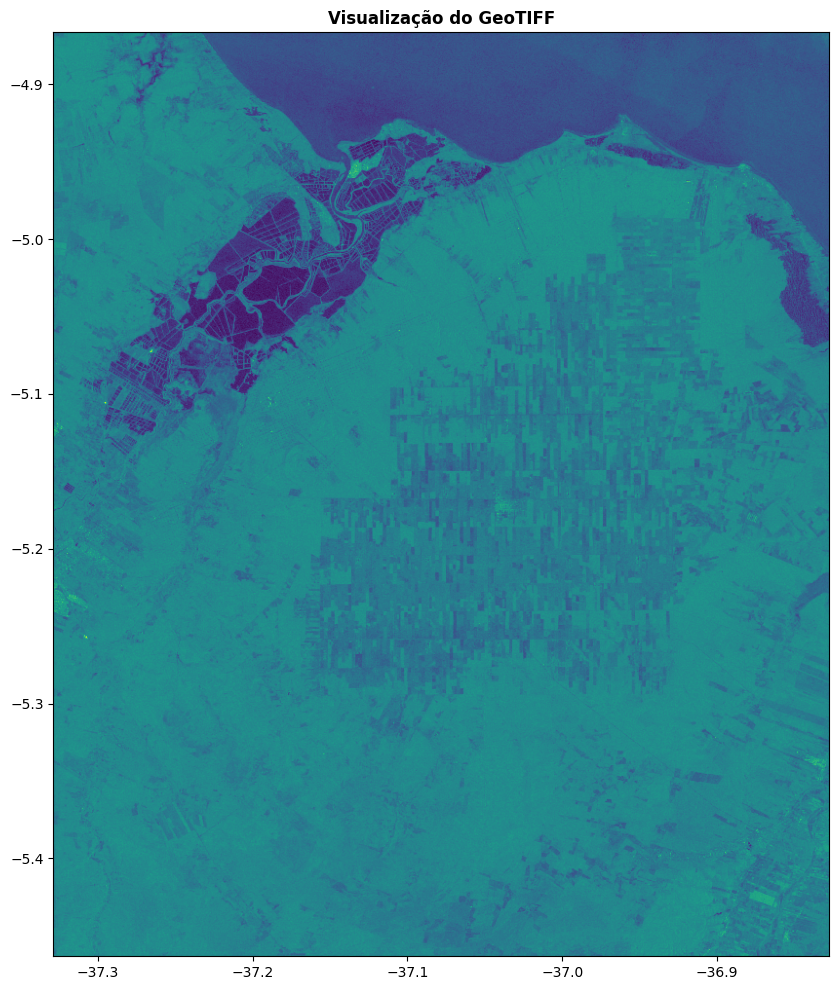

In [102]:
# Fazer o download do GeoTIFF
response = requests.get(url)
response.raise_for_status()  # Verificar se o download foi bem-sucedido

# Criar um arquivo temporário para salvar o GeoTIFF
with tempfile.NamedTemporaryFile(delete=False, suffix='.tif') as tmp_file:
    tmp_file.write(response.content)
    tmp_path = tmp_file.name

# Abrir e exibir o arquivo GeoTIFF
with rasterio.open(tmp_path) as src:

    # Configurar o tamanho da figura (exemplo: 12x12 polegadas)
    plt.figure(figsize=(12, 12))
    
    # Exibir o arquivo usando rasterio
    show(src, title="Visualização do GeoTIFF")

    # Mostrar a imagem plotada
    plt.show()

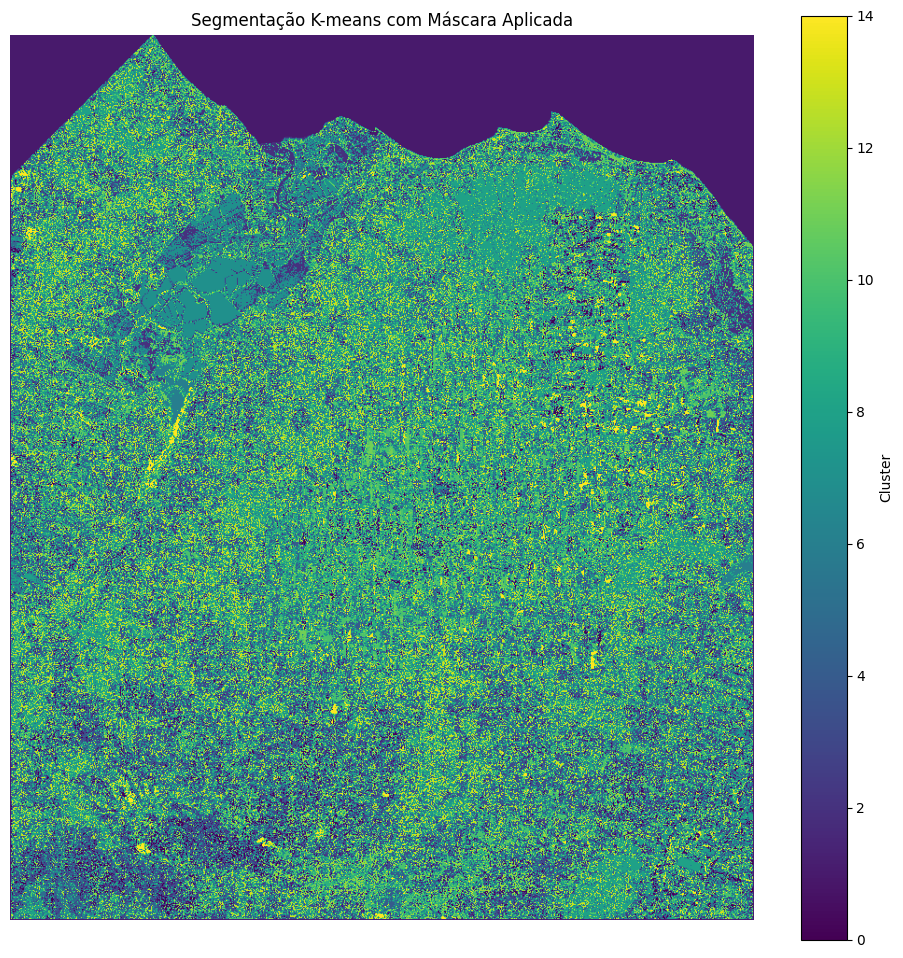

In [110]:
from sklearn.cluster import KMeans

# Obter a geometria do polígono da região filtrada e convertê-la para o formato GeoJSON
geometries = [gdf_a305.geometry.iloc[0]]

# Abrir o arquivo GeoTIFF e aplicar a máscara
with rasterio.open(tmp_path) as src:
    # Aplicar a máscara para manter apenas os pixels dentro da geometria de interesse
    out_image, out_transform = mask(src, geometries, crop=True)
    out_meta = src.meta.copy()

# Atualizar os metadados para o novo arquivo mascarado
out_meta.update({
    "driver": "GTiff",
    "height": out_image.shape[1],
    "width": out_image.shape[2],
    "transform": out_transform
})

# Usar os dados mascarados para segmentação
bands_data = np.array(out_image)

# Reshape para aplicar clustering
n_bands, height, width = bands_data.shape
reshaped_data = bands_data.reshape((n_bands, height * width)).T

# Aplicar K-means com um número de clusters
n_clusters = 15  # Número de segmentos desejados
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(reshaped_data)
segmented = kmeans.labels_.reshape((height, width))

# Visualizar a segmentação
plt.figure(figsize=(12, 12))
plt.imshow(segmented, cmap='viridis')
plt.title("Segmentação K-means com Máscara Aplicada")
plt.colorbar(label='Cluster')
plt.axis('off')
plt.show()


In [111]:
# Ver todas as classes (clusters) encontradas
unique_clusters = np.unique(segmented)
print("Clusters encontrados:", unique_clusters)

Clusters encontrados: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]


In [112]:
# printar a contagem de cada classe
for cluster in unique_clusters:
    count = np.sum(segmented == cluster)
    print(f"Cluster {cluster}: {count} pixels")
    

Cluster 0: 45925 pixels
Cluster 1: 86834 pixels
Cluster 2: 14191 pixels
Cluster 3: 106036 pixels
Cluster 4: 37828 pixels
Cluster 5: 81835 pixels
Cluster 6: 8258 pixels
Cluster 7: 14074 pixels
Cluster 8: 80049 pixels
Cluster 9: 66782 pixels
Cluster 10: 26669 pixels
Cluster 11: 12307 pixels
Cluster 12: 56014 pixels
Cluster 13: 98440 pixels
Cluster 14: 21111 pixels


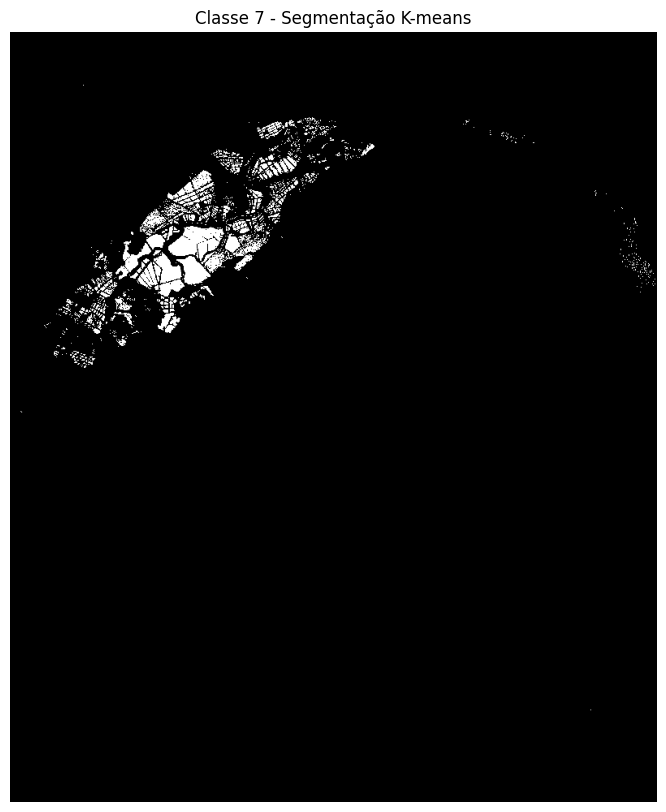

In [152]:
# Escolher a classe que deseja plotar
classe_desejada = 7

# Criar uma máscara binária para a classe desejada
mask_class = (segmented == classe_desejada)

# Visualizar apenas a classe desejada
plt.figure(figsize=(10, 10))
plt.imshow(mask_class, cmap='gray')
plt.title(f"Classe {classe_desejada} - Segmentação K-means")
plt.axis('off')
plt.show()

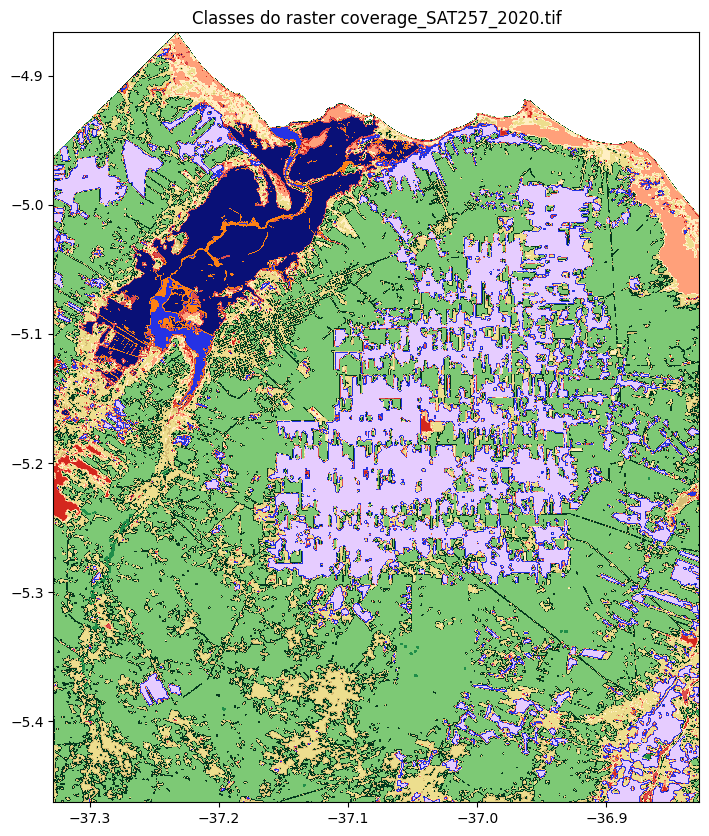

In [107]:
output_tif_path = '../dados/raster_tiff_caating_sat/2020/coverage_SAT257_2020.tif'
plot_tiff_with_classes(output_tif_path)

In [109]:
# Extrair informações do GeoTIFF salvo
sorted_class_counts = extract_classification_info(output_tif_path)

# printar a contagem de cada classe
for class_id, class_count in sorted_class_counts.items():
    print(f"Classe {class_id}: {class_count} pixels")
print("Numero de classes:", len(sorted_class_counts))

Classe 5: 1819 pixels
Classe 3: 6643 pixels
Classe 32: 7821 pixels
Classe 12: 13890 pixels
Classe 25: 23746 pixels
Classe 24: 26193 pixels
Classe 33: 64576 pixels
Classe 48: 95673 pixels
Classe 23: 95818 pixels
Classe 31: 179173 pixels
Classe 21: 229432 pixels
Classe 15: 350492 pixels
Classe 0: 458048 pixels
Classe 41: 592818 pixels
Classe 4: 1959330 pixels
Numero de classes: 15


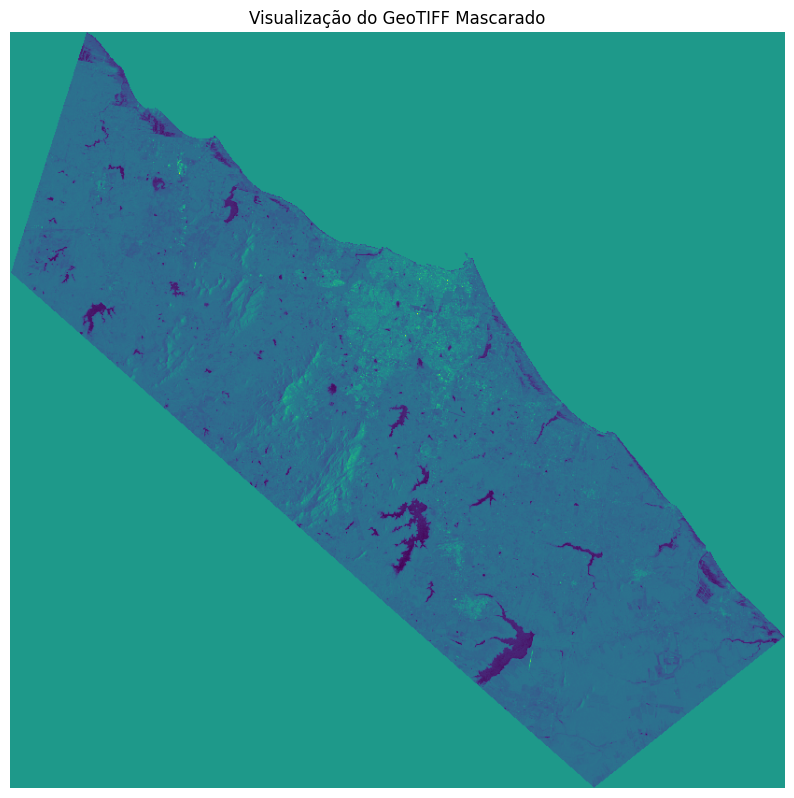

In [25]:
# Obter a geometria do polígono da região filtrada e convertê-la para o formato GeoJSON
geometries = [gdf_a305.geometry.iloc[0]]

# Abrir o arquivo GeoTIFF e aplicar a máscara
with rasterio.open(tmp_path) as src:
    out_image, out_transform = mask(src, geometries, crop=True)
    out_meta = src.meta.copy()

# Atualizar os metadados para o novo arquivo mascarado
out_meta.update({
    "driver": "GTiff",
    "height": out_image.shape[1],
    "width": out_image.shape[2],
    "transform": out_transform
})

# Exibir a imagem mascarada
plt.figure(figsize=(10, 10))
plt.imshow(out_image[0], cmap='viridis')
plt.title("Visualização do GeoTIFF Mascarado")
plt.axis('off')
plt.show()

# salvar o arquivo mascarado
output_path = '../dados/geotif_sentinel1_A305_2020.tif'
with rasterio.open(output_path, 'w', **out_meta) as dest:
    dest.write(out_image)

# Excluir o arquivo temporário
os.remove(tmp_path)

 Método de Segmentação:
Para segmentação de vegetação e corpos d'água, pode ser útil usar métodos de aprendizado de máquina, como Random Forest, em vez de apenas trabalhar com os dados brutos de radar. Para isso, você pode combinar as bandas VV e VH com índices derivados (como NDVI de Sentinel-2) e treinar um modelo.